In [506]:
import pandas as pd
import numpy as np
import os
import os.path, time
import zipfile as zp
import re
import random
from datetime import datetime, date
from datetime import datetime, timedelta
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from scipy import stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from statsmodels.base.model import LikelihoodModel

from numpy.random import randn
from numpy.random import seed
from scipy.stats import pearsonr
import unicodedata
#import seaborn as sns; sns.set()

### Subject List 

In [221]:
def sub_Dict():
    sub_Dict = dict({99: ['797','806','809','826','843','845','855','856','857'], 
                 114: ['1031','1153','1154','1157','1174','1262','1264','1266',
        '1364','1367','1379','1380','1381','1384','1435','1465','1467','1468','1489','1492','1493','1494','1495','1498','1519',
        '1520','1527','1532','1536','1541','1721','1722','1737','1741','1788','1791','1810','1812','1833','1934'],
        177:['2310','2316','2318','2323','2338','2339','2340','2348','2353','2356','2357','2358','2377',
            '2378','2381','2383','2385','2386','2387','2388','2389','2390','2391','2394','2395','2396','2399',
            '2401','2402','2404','2405','2407','2434','2444','2456']}) 
    return sub_Dict

def GetCohort(subID):
    subDict = sub_Dict()
    for key, value in subDict.items():
        if subID in value:
            return key
        
def subID_list():
    subID = ['797','806','809','826','843','845','855','856','857','1031','1153','1154','1157','1174','1262','1264','1266',
        '1364','1367','1379','1380','1381','1384','1435','1465','1467','1468','1489','1492','1493','1494','1495','1498','1519',
        '1520','1527','1532','1536','1541','1721','1722','1737','1741','1788','1791','1810','1812','1833','1934',
            '2310','2316','2318','2323','2338','2339','2340','2348','2353','2356','2357','2358','2377','2378',
             '2381','2383','2385','2386','2387','2388','2389','2390','2391','2394','2395','2396','2399',
             '2401','2402','2404','2405','2407','2434','2444','2456']
    return subID



## ESVT Model

In [372]:
def raw_data_df(sub,cohort):
    subID = subID_list()
    if cohort != 177:
        week_label = ['01','08','11','17','19','23','26','32','34','36','42','44','48','52','56']
    else:
        week_label = ['01','04','08','11','17','19','23','26','32','34','37','42','44','48','52','56']
    filelist = []
    file = []
    
    for i in range(len(week_label)):
        lottery_file = '/Users/zyy219/Documents/Risk_project/Data/RP/study_%s_Levy Probability Choice Task - Healthy North American_%s.zip'%(cohort,week_label[i])
        filelist += zp.ZipFile(lottery_file).namelist()
        file.append(zp.ZipFile(lottery_file))
        
    sub_file = {}
    for i in range(len(subID)):
        key = subID[i]
        sub_file.setdefault(key, [])
        sub_file[key].extend([s for s in filelist if subID[i] in s])


    appended_data = []
    for i in range(len(file)):
        
        data = pd.read_csv(file[i].open(sub_file[sub][i]))
        
        appended_data.append(data)
    df = pd.concat(appended_data)
    
    r = df[df['data_rounds_trial_type'] == 'risk']
    return r

def analysis_data_all(df,obs):
    df.data_rounds_selected_sure_bet_reward = df.data_rounds_selected_sure_bet_reward.astype(int)
    df_temp = df[['participant_id','data_rounds_reward_probability','data_rounds_reward_value','data_rounds_selected_sure_bet_reward']]
    df_temp.loc[:,'data_rounds_selected_sure_bet_reward'] = df_temp['data_rounds_selected_sure_bet_reward'].replace({0:1, 1:0})
    df_temp = df_temp.rename(columns={"data_rounds_selected_sure_bet_reward": "data_rounds_selected_variable_bet_reward"})
    x = np.array(df_temp['data_rounds_reward_value'])
    x = np.reshape(x,[obs,1])
    s = 5*np.ones((obs,1))
    p = np.array(df_temp['data_rounds_reward_probability'])
    p = np.reshape(p,[obs,1])
    

    SubjectChoices = np.array(df_temp['data_rounds_selected_variable_bet_reward'])
    SubjectChoices = np.reshape(SubjectChoices,[obs,1])
    exog = np.concatenate((x,s,p), axis=1)
    endog = SubjectChoices

    return df_temp, exog, endog  

def sv(x,p,s,gamma,alpha,M):
    
    SV_X = p*(np.power(x,alpha)/(np.power(x,alpha)+np.power(M,alpha)))
    SV_Y = np.power(s,alpha)/(np.power(s,alpha)+np.power(M,alpha))
    
    #logisitc regression 
    #difference between subjective value
    prob = 1/(1+np.exp(-gamma*(SV_X-SV_Y)))
    return prob

def _ll_nb2_ESVT(enog, exog, alpha, M, gamma):

    x = exog[:,0]
    s = exog[:,1]
    p = exog[:,2]
    SV_X = p*(np.power(x,alpha)/(np.power(x,alpha)+np.power(M,alpha)))
    SV_Y = np.power(s,alpha)/(np.power(s,alpha)+np.power(M,alpha))
    prob = 1/(1+np.exp(-gamma*(SV_X-SV_Y)))
    temp = 1-prob
    prob[enog == 0] = temp[enog == 0]
    negLL = -np.sum(np.log(prob))
    return negLL

class ESVT(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(ESVT, self).__init__(endog, exog, **kwds)

    def nloglikeobs(self,parms):
        alpha = parms[0]
        M = parms[1]
        gamma = parms[2]
        negll = _ll_nb2_ESVT(self.endog, self.exog, alpha, M, gamma)          
        return negll

    def fit(self, start_params, method='L-BFGS-B',bounds = ((1, None), (0, None), (0, None)) ,maxiter=10000, maxfun=50000, **kwds):
        #if start_params == None:
            # Reasonable starting values
            #start_params = np.array([3.5,14,25])
            
        return super(ESVT, self).fit(start_params=start_params,method='lbfgs',bounds = ((1, None), (0, None), (0, None)),
                                     maxiter=maxiter, maxfun=maxfun,
                                     **kwds)

## ESVT fitting

In [444]:
sub

['2310',
 '2316',
 '2318',
 '2323',
 '2338',
 '2339',
 '2340',
 '2348',
 '2353',
 '2356',
 '2357',
 '2358',
 '2377',
 '2378',
 '2381',
 '2383',
 '2385',
 '2386',
 '2387',
 '2388',
 '2389',
 '2390',
 '2391',
 '2394',
 '2395',
 '2396',
 '2399',
 '2401',
 '2402',
 '2404',
 '2405',
 '2407',
 '2434',
 '2444',
 '2456']

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


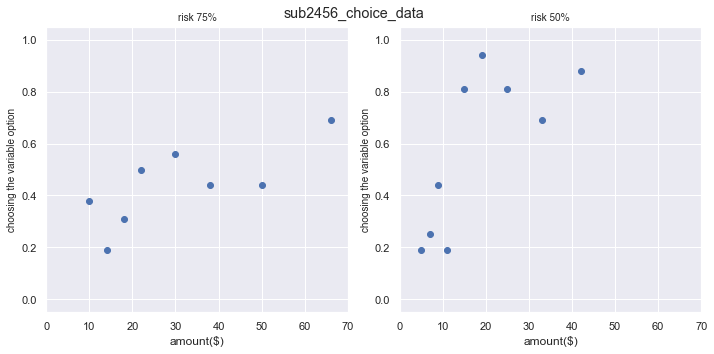

In [460]:
trialNo = 272
xx = np.arange(0,trialNo,1)
xx = xx.reshape(trialNo,1)

p_risk_high = 0.25*np.ones((trialNo,1))
p_risk_low = 0.5*np.ones((trialNo,1))
s = 5*np.ones((trialNo,1))



df = raw_data_df(sub[34],177)
df_temp, exog, endog = analysis_data_all(df,272)


risk_high = df_temp.query('data_rounds_reward_probability == 0.25').sort_values(by=['data_rounds_reward_value'])
risk_low = df_temp.query('data_rounds_reward_probability == 0.5').sort_values(by=['data_rounds_reward_value'])

sv_risk_high = sv(xx,p_risk_high,s,res.params[2],res.params[0],res.params[1])
sv_risk_low = sv(xx,p_risk_low,s,res.params[2],res.params[0],res.params[1])

risk_high_d = risk_high[['data_rounds_reward_value', 'data_rounds_selected_variable_bet_reward']]
risk_high_ratio = round(risk_high_d.groupby(risk_high_d.data_rounds_reward_value).sum()/16,2)

risk_low_d = risk_low[['data_rounds_reward_value', 'data_rounds_selected_variable_bet_reward']]
risk_low_ratio = round(risk_low_d.groupby(risk_low_d.data_rounds_reward_value).sum()/16,2)

reward_value_risk_low = risk_low_ratio.index.to_list()
reward_value_risk_high = risk_high_ratio.index.to_list()


## Plot 
fig, ax = plt.subplots(figsize=(10, 5))
#plt.suptitle('sub%s_choice_data\n gamma = %2.2f alpha = %2.2f M = %2.2f'%(sub,res.params[2],res.params[0],res.params[1]), y = 1,fontname="Helvetica", fontsize=12)
plt.suptitle('sub%s_choice_data'%sub[34])
ax1 = plt.subplot(121)


#plt.plot(xx, sv_risk_high,'pink')
plt.scatter(reward_value_risk_high, risk_high_ratio['data_rounds_selected_variable_bet_reward'])
ax1.set_xlabel('amount($)')
ax1.set_ylabel("choosing the variable option", fontname="Helvetica", fontsize=10)
ax1.set_title("risk 75%", fontname= "Helvetica", fontsize=10,loc='center')

ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)

#plt.plot(xx, sv_risk_low,'pink')
plt.scatter(reward_value_risk_low, risk_low_ratio['data_rounds_selected_variable_bet_reward'])
ax2.set_xlabel('amount($)')
ax2.set_ylabel("choosing the variable option", fontname="Helvetica", fontsize=10)
ax2.set_title("risk 50%", fontname= "Helvetica", fontsize=10,loc='center')
plt.subplots_adjust(bottom=-1, right=0.8, top=0.8)
plt.xlim(0, 70)
plt.ylim(-0.05,1.05)
plt.tight_layout()
plt.savefig('../../Figures/lottery_choice_data/All/ESVT_fitting/sub%s_risk_choice_ESVT.png'%sub[34],dpi=1000)
plt.show()

In [241]:
subID = subID_list()
subNo = len(subID)

ESVT_alpha = np.empty([subNo , 1])
ESVT_M = np.empty([subNo , 1])
ESVT_gamma = np.empty([subNo, 1])


for i in range(subNo):
    df = raw_data_df(subID[i],GetCohort(subID[i]))
    if GetCohort(subID[i])== 177:
        obs = 272
    else:
        obs = 255
    df_temp, exog, endog = analysis_data_all(df,obs)
    mod = ESVT(endog, exog)
    res = mod.fit()
    ESVT_alpha[i] = res.params[0]
    #print(ESVT_alpha[i])
    ESVT_M[i] = res.params[1]
    print(ESVT_M)
    ESVT_gamma[i] = res.params[2]
        
        
   

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in power
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in 

## Expected Utility Model 

In [344]:
def raw_data(week,sub,cohort):
    subID = subID_list()
    if cohort !=177:
        week_label = [['01','01'],['08','11'],['17','19'],['23','26'],['32','34'],['36','42'],['44','48'],['52','56']]
    else:
        week_label = [['01','04'],['08','11'],['17','19'],['23','26'],['32','34'],['37','42'],['44','48'],['52','56']]
    lottery_file_1 = '/Users/zyy219/Documents/Risk_project/Data/RP/study_%s_Levy Probability Choice Task - Healthy North American_%s.zip'%(cohort, week_label[week-1][0])
    filelist_1 = zp.ZipFile(lottery_file_1).namelist()
    lottery_file_2 = '/Users/zyy219/Documents/Risk_project/Data/RP/study_%s_Levy Probability Choice Task - Healthy North American_%s.zip'%(cohort, week_label[week-1][1])
    filelist_2 = zp.ZipFile(lottery_file_2).namelist()
    
    sub_file = {}
    for i in range(len(subID)):
        key = subID[i]
        sub_file.setdefault(key, [])
        sub_file[key].extend([s for s in filelist_1 if subID[i] in s])
        sub_file[key].extend([s for s in filelist_2 if subID[i] in s])

    df1 = pd.read_csv(zp.ZipFile(lottery_file_1).open(sub_file[sub][0]))
    df2 = pd.read_csv(zp.ZipFile(lottery_file_2).open(sub_file[sub][1]))
    df = pd.concat([df1, df2])
    
    return df

def analysis_data_weekly(df):
    df.data_rounds_selected_sure_bet_reward = df.data_rounds_selected_sure_bet_reward.astype(int)
    df_temp = df[['participant_id','data_rounds_reward_probability','data_rounds_reward_value','data_rounds_selected_sure_bet_reward','data_rounds_trial_type','data_rounds_ambiguity']]
    df_temp.loc[df.data_rounds_trial_type  == 'ambiguity', 'data_rounds_reward_probability'] = 0.5
    df_temp.loc[:,'data_rounds_selected_sure_bet_reward'] = df_temp['data_rounds_selected_sure_bet_reward'].replace({0:1, 1:0})
    df_temp = df_temp.rename(columns={"data_rounds_selected_sure_bet_reward": "data_rounds_selected_variable_bet_reward"})
    x = np.array(df_temp['data_rounds_reward_value'])
    x = np.reshape(x,[70,1])
    p = np.array(df_temp['data_rounds_reward_probability'])
    p = np.reshape(p,[70,1])
    s = 5*np.ones((70,1))
    A = np.array(df['data_rounds_ambiguity'])
    A = np.reshape(A,[70,1])
    SubjectChoices = np.array(df_temp['data_rounds_selected_variable_bet_reward'])
    SubjectChoices = np.reshape(SubjectChoices,[70,1])
    exog = np.concatenate((x,p,s,A), axis=1)
    endog = SubjectChoices

    return exog, endog   

def _ll_nb2_EU(enog, exog, alpha, beta, gamma):

    x = exog[:,0]
    p = exog[:,1]
    s = exog[:,2]
    A = exog[:,3]
    SV_X = (p-beta*(A/2)) * np.power(x,alpha)
    SV_Y = np.power(s,alpha)
    prob = 1/(1+np.exp(-gamma*(SV_X-SV_Y)))
    temp = 1-prob
    prob[enog == 0] = temp[enog == 0]
    negLL = -np.sum(np.log(prob))
    #negLL = -np.log(prob)
    return negLL

class EU(GenericLikelihoodModel):
#class Bin(LikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(EU, self).__init__(endog, exog, **kwds)

    def nloglikeobs(self,parms):
        alpha = parms[0]
        beta = parms[1]
        gamma = parms[2]
        negll = _ll_nb2_EU(self.endog, self.exog, alpha, beta, gamma)          
        return negll
    

    def fit(self, start_params=None, method='L-BFGS-B',bounds = ((0, None), (-1, 1), (0, None)) ,maxiter=10000, maxfun=50000, **kwds):
        # we have one additional parameter and we need to add it for summary
        #self.exog_names.append('gamma')
        if start_params == None:
            # Reasonable starting values
            start_params = np.array([0.9,0,1])
            # intercept
            #start_params[-2] = np.log(self.endog.mean())
        return super(EU, self).fit(start_params=start_params,method='lbfgs',bounds = ((0, None), (-1, 1), (0, None)),
                                     maxiter=maxiter, maxfun=maxfun,
                                     **kwds)



## Choice ratio & RT

In [342]:
def rp_ratio(week,sub,cohort):
    df = raw_data(week,sub,cohort)

    
    amb = df.query('data_rounds_trial_type == "ambiguity"')
    amb_d = amb[['data_rounds_reward_value', 'data_rounds_selected_sure_bet_reward']]
    amb_ratio = 1 - (round(amb_d.data_rounds_selected_sure_bet_reward.sum()/36,2))
  
    risk = df.query('data_rounds_trial_type == "risk"')
    risk_d = risk[['data_rounds_reward_value', 'data_rounds_selected_sure_bet_reward']]
    risk_ratio = 1 - (round(risk_d.data_rounds_selected_sure_bet_reward.sum()/34,2))
    
    return amb_ratio, risk_ratio

def RT(week,sub,cohort):
    subID = subID_list()
    
    if cohort != 177:
        week_label = [['01','01'],['08','11'],['17','19'],['23','26'],['32','34'],['36','42'],['44','48'],['52','56']]
    else:
        week_label = [['01','04'],['08','11'],['17','19'],['23','26'],['32','34'],['37','42'],['44','48'],['52','56']]
    
    lottery_file_1 = '/Users/zyy219/Documents/Risk_project/Data/RP/study_%s_Levy Probability Choice Task - Healthy North American_%s.zip'%(cohort, week_label[week-1][0])
    filelist_1 = zp.ZipFile(lottery_file_1).namelist()
    lottery_file_2 = '/Users/zyy219/Documents/Risk_project/Data/RP/study_%s_Levy Probability Choice Task - Healthy North American_%s.zip'%(cohort, week_label[week-1][1])
    filelist_2 = zp.ZipFile(lottery_file_2).namelist()

    sub_file = {}
    for i in range(len(subID)):
        key = subID[i]
        sub_file.setdefault(key, [])
        sub_file[key].extend([s for s in filelist_1 if subID[i] in s])
        sub_file[key].extend([s for s in filelist_2 if subID[i] in s])

    df1 = pd.read_csv(zp.ZipFile(lottery_file_1).open(sub_file[sub][0]))
    RT_start = df1['start_time'].to_list()
    RT_end = df1['end_time'].to_list()
    s = list(set(RT_start))
    e = list(set(RT_end))
    dt_start = datetime.strptime(s[0][0:19], "%Y-%m-%d %H:%M:%S").time()
    dt_end = datetime.strptime(e[0][0:19], "%Y-%m-%d %H:%M:%S").time()

    RT1 = datetime.combine(date.today(), dt_end) - datetime.combine(date.today(), dt_start)

    df2 = pd.read_csv(zp.ZipFile(lottery_file_2).open(sub_file[sub][1]))
    RT_start = df2['start_time'].to_list()
    RT_end = df2['end_time'].to_list()
    s = list(set(RT_start))
    e = list(set(RT_end))
    dt_start = datetime.strptime(s[0][0:19], "%Y-%m-%d %H:%M:%S").time()
    dt_end = datetime.strptime(e[0][0:19], "%Y-%m-%d %H:%M:%S").time()

    RT2 = datetime.combine(date.today(), dt_end) - datetime.combine(date.today(), dt_start)
    mean_RT = (RT1+RT2)/2
    return RT1, RT2

In [345]:
all_amb_ratio = np.empty([subNo, 8])
all_risk_ratio = np.empty([subNo, 8])
all_RT = np.empty([subNo, 8])
week = [1,2,3,4,5,6,7,8]
for i in range(len(subID)):
    for t in range(len(week)):
        cohort = GetCohort(subID[i])
        amb_ratio, risk_ratio = rp_ratio(week[t],subID[i],cohort)
        all_amb_ratio[i][t] =  amb_ratio
        all_risk_ratio[i][t] = risk_ratio
        RT1, RT2 = RT(week[t],subID[i],cohort)
        meanRT = (RT1.total_seconds()+RT2.total_seconds())/2
        all_RT[i][t] = meanRT

In [525]:
mean_amb_ratio = np.mean(all_amb_ratio, axis = 1).reshape([len(subID),1])
mean_risk_ratio = np.mean(all_risk_ratio, axis = 1).reshape([len(subID),1])
mean_RT = np.mean(all_RT,axis = 1).reshape([len(subID),1])

#plt.hist(all_amb_ratio.reshape([8*84,1]))
ratio_rt_data = np.concatenate((mean_risk_ratio,mean_amb_ratio,mean_RT),axis = 1)

In [529]:
np.sum(np.mean(all_amb_ratio, axis = 1)<=0.1)
all_risk_ratio
#plt.hist(all_risk_ratio.reshape(672,1))
np.mean(all_risk_ratio, axis = 1)

ratio_rt_df = pd.DataFrame(data=ratio_rt_data,
                            columns=["risk_ratio","amb_ratio","RT"])
ratio_rt_df

,risk_ratio,amb_ratio,RT
0,0.38000,0.17375,106.3125
1,0.40625,0.45375,124.3750
2,0.42500,0.34250,101.3750
3,0.49000,0.51125,89.7500
4,0.42250,0.25500,132.8125
5,0.33000,0.24000,195.8125
6,0.23875,0.38500,245.3750
7,0.36875,0.07500,395.8125
8,0.75250,0.07000,98.3125
9,0.50625,0.45250,72.5625


Combine all depedent variables to a dataframe 

In [100]:
sub_array = np.empty([subNo , 1])
sub_array[:,0] = subID_list()
# = np.concatenate((np.round(ESVT_alpha,3), np.round(ESVT_M,3), np.round(ESVT_gamma,3), 
                        #mean_amb_ratio, mean_risk_ratio, mean_RT), axis=1)

#df = pd.DataFrame(data=all_p,index = subID_list(),columns=["all_alpha", "all_M","all_gamma"])
#df.to_csv('out_large_gamma.csv',index=True)
#p = np.concatenate(mean_amb_ratio, mean_risk_ratio, mean_RT,axis = 1)
dependent = np.empty([49,9])
dependent[:,0] = mean_risk_ratio
dependent[:,1] = np.mean(EU_alpha,axis = 1)
dependent[:,2] = mean_amb_ratio
dependent[:,3] = np.mean(EU_beta, axis = 1)
dependent[:,4] = np.mean(EU_gamma, axis = 1)
dependent[:,5] = np.reshape(ESVT_alpha,(49))
dependent[:,6] = np.reshape(ESVT_M,(49))
dependent[:,7] = np.reshape(ESVT_gamma,(49))
dependent[:,8] = mean_RT
dependent_df = pd.DataFrame(data=dependent,index = subID_list(),
                            columns=["risk_ratio","EU_alpha","amb_ratio","EU_beta","EU_gamma",
                                     "ESVT_alpha","ESVT_M","ESVT_gamma","RT"])
dependent_df

,risk_ratio,EU_alpha,amb_ratio,EU_beta,EU_gamma,ESVT_alpha,ESVT_M,ESVT_gamma,RT
797,0.38000,0.587106,0.17375,0.644556,3.803372,1.000000,25.089405,59.260606,106.3125
806,0.40625,0.670514,0.45375,0.451620,2.173946,1.000000,22.346885,28.276932,124.3750
809,0.42500,0.681028,0.34250,0.532345,1.935678,1.000000,38.136841,33.921683,101.3750
826,0.49000,0.757212,0.51125,0.372419,1.951932,1.000000,38.431532,48.135757,89.7500
843,0.42250,0.543544,0.25500,0.769761,1.252187,1.000000,20.690549,9.217044,132.8125
845,0.33000,0.578804,0.24000,0.484805,65.793278,1.000000,16.954770,20.505699,195.8125
855,0.23875,0.302094,0.38500,-0.058343,2.351478,3.976270,4.684728,7.391716,245.3750
856,0.36875,0.217867,0.07500,0.984848,2.087430,1.000000,22.699432,0.000000,395.8125
857,0.75250,0.559200,0.07000,0.985055,0.851918,123.350231,9.026708,3.385342,98.3125
1031,0.50625,0.263745,0.45250,0.655100,0.471952,1.003817,27.788347,0.000000,72.5625


## McFadden’s pseudo R-squareds

In [212]:

def r_squared_EU(alpha,beta,gamma,exog,enog,obs):
    x = exog[:,0]
    p = exog[:,1]
    s = exog[:,2]
    A = exog[:,3]

    SV_X = (p-beta*(A/2)) * np.power(x,alpha)
    SV_Y = np.power(s,alpha)
    prob = 1/(1+np.exp(-gamma*(SV_X-SV_Y))).reshape((obs,1))
    temp = 1-prob
    prob[enog == 0] = temp[enog == 0]
    full_m_ll  = np.sum(np.log(prob))
    null_m_ll = -obs*np.log(2)
    r = 1- full_m_ll/null_m_ll
    return r

## ESVT R Squared

In [373]:
def r_square_ESVT(alpha,M,gamma,exog,enog,obs):

    x = exog[:,0]
    s = exog[:,1]
    p = exog[:,2]
    SV_X = p*(np.power(x,alpha)/(np.power(x,alpha)+np.power(M,alpha)))
    SV_Y = np.power(s,alpha)/(np.power(s,alpha)+np.power(M,alpha))
    prob = 1/(1+np.exp(-gamma*(SV_X-SV_Y))).reshape(obs,1)

    temp = 1-prob

    prob[enog == 0] = temp[enog == 0]
    LL = np.sum(np.log(prob))
    null_m_ll = -obs*np.log(2)
    full_m_ll = LL
    r = 1- full_m_ll/null_m_ll
    return r

In [375]:
alpha_sp = np.array([3.5,1.5,2])
M_sp = np.array([14,25,50])
gamma_sp = np.array([14,25,50])
sp = []
for i in alpha_sp:
    for t in M_sp:
        for r in gamma_sp:
            sp.append(np.array([i,t,r]))
            

In [397]:
rs = []
f_dict = {}
for t in range(27):
    params_array = np.empty([len(subID),4])
    for i in range(len(subID)):
        if GetCohort(subID[i]) != 177:
            obs = 255
        else:
            obs = 272
        dd = raw_data_df(subID[i],GetCohort(subID[i]))
        df_temp, exog, endog = analysis_data_all(dd,obs)
        mod = ESVT(endog, exog)
        res = mod.fit(sp[t])
        params_array[i,0:3] = res.params
        alpha = res.params[0]
        M = res.params[1]
        gamma = res.params[2]
        r = r_square_ESVT(alpha,M,gamma,exog,endog,obs)
        params_array[i,3] = r
        fitting_df = pd.DataFrame(data=np.round(params_array,3), index=subID_list(), columns=["alpha", "M","Gamma","R_squared"])
        f_dict[t] = fitting_df

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in power
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in power
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWar

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

In [400]:
r_df = np.empty([len(subID),27])
for i in range(27):
    r_df[:,i]= f_dict[i]['R_squared']

In [485]:
len(subID)
R = ['855','856','857','1031','1364','1381','1435','1492','1493',
     '1519','1721','2310','2338','2340','2356','2378','2387','2444']
N = [i for i in range(len(subID)) if subID[i] in R]
N

[6, 7, 8, 9, 17, 21, 23, 28, 29, 33, 39, 49, 53, 55, 58, 62, 67, 82]

In [215]:
obs = 70
r_square = np.empty([len(subID),len(week)])
for i in range(len(subID)):
    for t in range(len(week)):
        d = raw_data(week[t],subID[i],GetCohort(subID[i]))
        exog, enog = analysis_data_weekly(d)
        alpha = EU_alpha[i,t]
        beta = EU_beta[i,t]
        gamma = EU_gamma[i,t]
        r_square[i,t] = r_squared_EU(alpha,beta,gamma,exog,enog,obs)

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


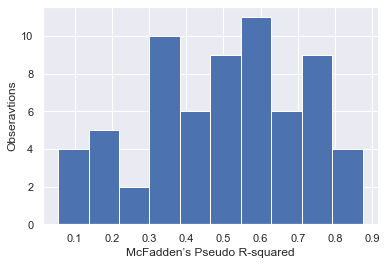

In [513]:
rr_df = pd.DataFrame(data=r_df)
rr_df
sr_df = rr_df.drop(N)
sr_df
max_sr = sr_df.max(axis=1)
max_sr

plt.hist(max_sr,bins = 10)

plt.xlabel('McFadden’s Pseudo R-squared')
plt.ylabel('Obseravtions')
plt.savefig('../../Figures/Presentation_Figure/VAF.png',dpi=1000)

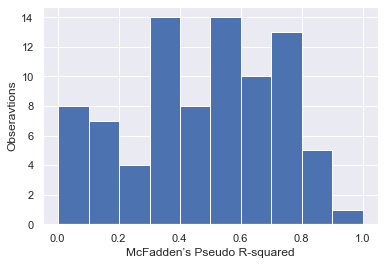

In [515]:
#create another column with the sp[idx_r]
max_r = rr_df.max(axis=1)
idx_r = rr_df.idxmax(axis = 1)
plt.hist(max_r,bins =10)
plt.xlabel('McFadden’s Pseudo R-squared')
plt.ylabel('Obseravtions')
plt.savefig('../../Figures/Presentation_Figure/VAF_all.png',dpi=1000)


In [547]:
sratio_rt_df = ratio_rt_df.drop(N)


-0.2996591587500778
-0.1040611411701901


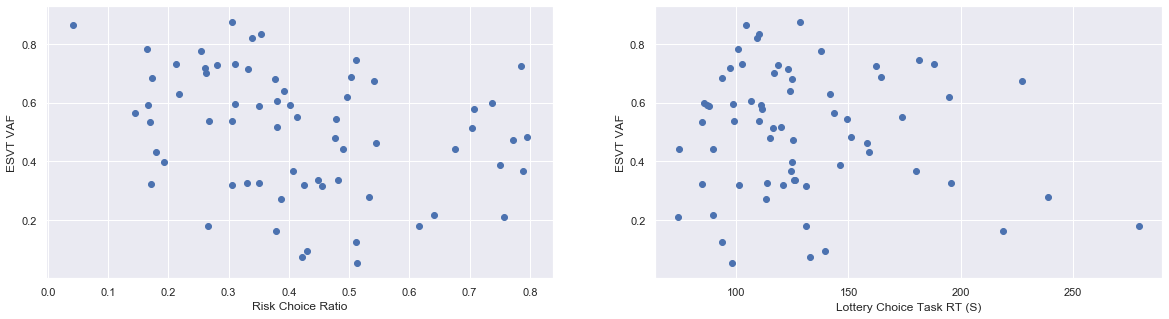

In [562]:
fig, ax = plt.subplots(figsize=(20, 5))
ax1 = plt.subplot(121)
plt.scatter(sratio_rt_df['risk_ratio'],max_sr)
plt.xlabel('Risk Choice Ratio')
plt.ylabel('ESVT VAF')
print(sratio_rt_df['risk_ratio'].corr(max_sr))

ax2 = plt.subplot(122)
plt.scatter(sratio_rt_df['RT'],max_sr)
plt.xlabel('Lottery Choice Task RT (S)')
plt.ylabel('ESVT VAF')

print(sratio_rt_df['RT'].corr(max_sr))

0.20854112947713427
0.08734109020019272


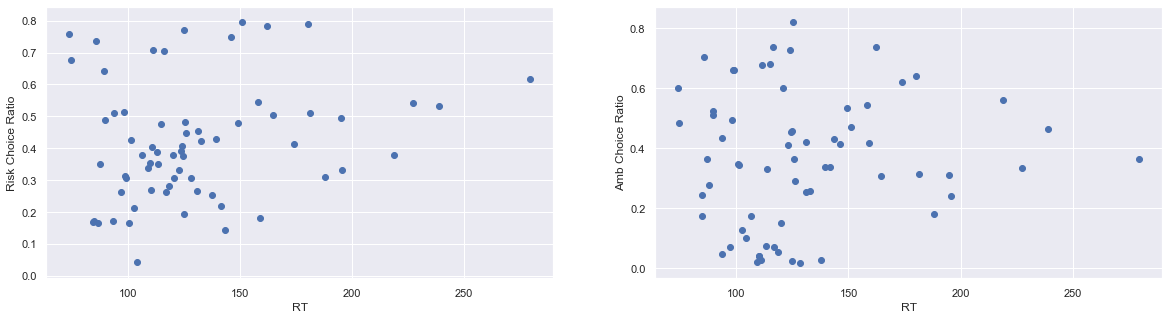

In [564]:
fig, ax = plt.subplots(figsize=(20, 5))
ax1 = plt.subplot(121)
plt.scatter(sratio_rt_df['RT'],sratio_rt_df['risk_ratio'])
plt.xlabel('RT')
plt.ylabel('Risk Choice Ratio')
print(sratio_rt_df['RT'].corr(sratio_rt_df['risk_ratio']))

ax2 = plt.subplot(122)
plt.scatter(sratio_rt_df['RT'],sratio_rt_df['amb_ratio'])
plt.xlabel('RT')
plt.ylabel('Amb Choice Ratio')
print(sratio_rt_df['RT'].corr(sratio_rt_df['amb_ratio']))